In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import auc, accuracy_score
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
cancer = pd.read_csv('../HW1/cancer.csv')
cancer.head()

,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
cancer_y = cancer.label.values
cancer_x = cancer.loc[:, '1':'30'].values
cancer_features = cancer.drop(['label'], axis=1).columns.values

In [15]:
spam = pd.read_csv('../HW1/spam.csv')
spam.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_:,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [16]:
spam_y = spam.label.values
spam_x = spam.loc[:, 'word_freq_make':'capital_run_length_total'].values
spam_features = spam.drop(['label'], axis=1).columns.values

# 1. Подсчет ROC AUC для пороговых условий 

In [22]:
def best_thr_features(x, y, features, dataset, pos_lbl=1, neg_lbl=0, step=30):
    n = x.shape[0]
    n_pos = sum([1 if l == pos_lbl else 0 for l in y])
    n_neg = n - n_pos
    
    features_scores = []

    for i in range(x.shape[1]):
        col_sorted, idx_sorted = zip(*sorted(zip(x[:, i], range(n))))
        
        min_, max_ = col_sorted[0], col_sorted[n - 1]
#         print(min_, max_)
        min_label = y[idx_sorted[0]]
        max_label = pos_lbl if min_label == neg_lbl else neg_lbl
        
        thresholds = [np.unique(col_sorted)[i] 
                      for i in np.linspace(0, len(np.unique(col_sorted)) - 1, 30, dtype=int)]
        tp_fp = np.zeros((step, 2))

        col_idx = 0
        for j in range(step):
            while col_idx + 1 < n and col_sorted[col_idx + 1] <= thresholds[j]:
                col_idx += 1
            
            # indexes for columns which is > thresholds and classified as max_label
            if max_label == pos_lbl:
                for k in range(col_idx + 1, n):
                    if y[idx_sorted[k]] == pos_lbl:
                        tp_fp[j, 0] += 1
                    else:
                        tp_fp[j, 1] += 1
            else:
                for k in range(0,col_idx + 1):
                    if y[idx_sorted[k]] == pos_lbl:
                        tp_fp[j, 0] += 1
                    else:
                        tp_fp[j, 1] += 1

        tp_fp[:, 0] /= n_pos
        tp_fp[:, 1] /= n_neg
        if auc(tp_fp[:, 1], tp_fp[:, 0]) < 0.5:
            tp_fp = tp_fp[:, [1, 0]]
        features_scores.append((auc(tp_fp[:, 1], tp_fp[:, 0]), tp_fp))


    features_scores, idx_sorted = zip(*sorted(zip(features_scores, range(x.shape[1])), 
                                  reverse=True))
    
    print(f'Датасет: {dataset}\n'
          f'Топ-3 признаков по значению roc-auc: {[features[i] for i in idx_sorted[:3]]}\n'
          f'ROC-AUC топ-3х признаков: {[s[0] for s in features_scores[:3]]}')
    for i in range(3):
        plt.plot(features_scores[i][1][:, 1], features_scores[i][1][:, 0])
        plt.title(f'roc кривая для признака {features[idx_sorted[i]]}')
        plt.show()

Датасет: cancer
Топ-3 признаков по значению roc-auc: ['23', '21', '24']
ROC-AUC топ-3х признаков: [0.9714404629776439, 0.9679258495851171, 0.9663865546218487]


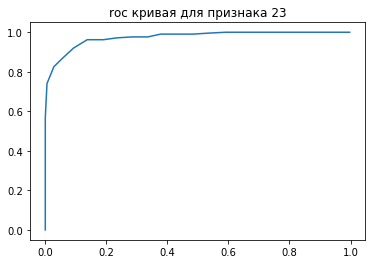

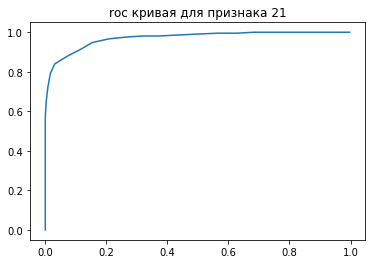

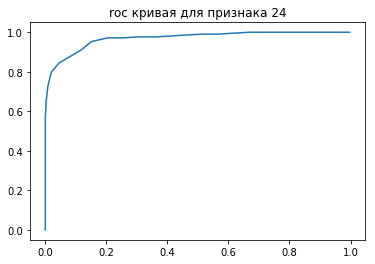

In [25]:
best_thr_features(cancer_x, cancer_y, cancer_features, 'cancer', 'M', 'B')

Датасет: spam
Топ-3 признаков по значению roc-auc: ['capital_run_length_longest', 'capital_run_length_average', 'char_freq_!']
ROC-AUC топ-3х признаков: [0.7961141279188011, 0.787113197289463, 0.7678398320435624]


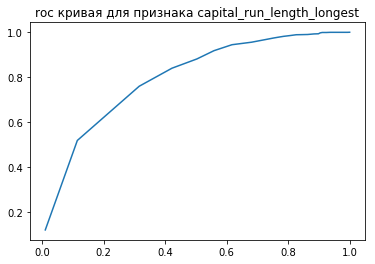

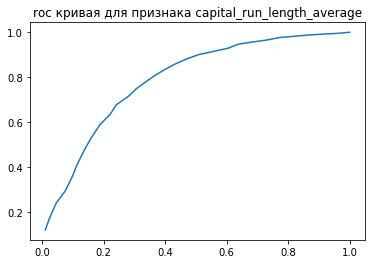

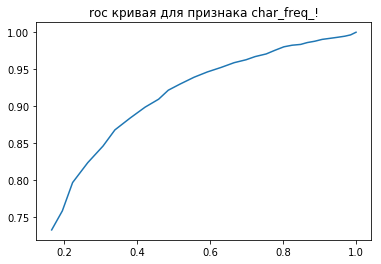

In [24]:
best_thr_features(spam_x, spam_y, spam_features, dataset='spam')

# 2. Разделение датасетов на train/test

In [29]:
def splitter(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y)
    
    def __printer(a, name):
        lbls, counts = np.unique(a, return_counts=True)
        print(f'Пропорции классов в {name} датасете:\n'
              f'\t{lbls[0]}: {counts[0] / len(a)}; {lbls[1]}: {counts[1] / len(a)}\n')
    
    __printer(y, 'исходном')
    __printer(y_train, 'обучающем')
    __printer(y_test, 'валидационном')
    
    return x_train, x_test, y_train, y_test

In [30]:
cancer_x_train, cancer_x_validate, \
    cancer_y_train, cancer_y_validate = splitter(cancer_x, cancer_y)

Пропорции классов в исходном датасете:
	B: 0.6274165202108963; M: 0.37258347978910367

Пропорции классов в обучающем датасете:
	B: 0.6263736263736264; M: 0.37362637362637363

Пропорции классов в валидационном датасете:
	B: 0.631578947368421; M: 0.3684210526315789



In [45]:
spam_x_train, spam_x_validate, \
    spam_y_train, spam_y_validate = splitter(spam_x, spam_y)

Пропорции классов в исходном датасете:
	0: 0.6059552271245382; 1: 0.39404477287546186

Пропорции классов в обучающем датасете:
	0: 0.6059782608695652; 1: 0.39402173913043476

Пропорции классов в валидационном датасете:
	0: 0.6058631921824105; 1: 0.3941368078175896



# 3. Реализация алгоритма построения дерева

In [39]:
def tree_builder(x, y, metrics, depth, max_depth, rules, idx, N, pos_lbl=1, neg_lbl=0):
    lbls, counts = np.unique(y, return_counts=True)
    if len(lbls) == 1:
        rules[idx] = [lbls[0]]
        return lbls[0]
    if depth == max_depth:
        rules[idx] = [lbls[np.argmax(counts)]] 
        return lbls[np.argmax(counts)]
    
    best_params = [-1 for _ in range(x.shape[1])]
    best_metric = [-1 for _ in range(x.shape[1])]
    n = x.shape[0]
    for i in range(x.shape[1]):
        col_sorted, idx_sorted = zip(*sorted(zip(x[:, i], 
                                                 range(n))))
        min_, max_ = col_sorted[0], col_sorted[n - 1]
        thresholds = np.linspace(min_, max_, 30)
        
        col_idx = 0
        for j in range(30):
            while col_idx + 1 < n and col_sorted[col_idx + 1] <= thresholds[j]:
                col_idx += 1
            
            left = [y[i] for i in idx_sorted[:col_idx + 1]]
            right = [y[i] for i in idx_sorted[col_idx + 1:]]
            
            if left == [] or right == []:
                continue
                
            if metrics(y, left, right, N) > best_metric[i]:
                best_params[i] = thresholds[j]
                best_metric[i] = metrics(y, left, right, N)
                
    if len(np.argwhere(best_metric == max(best_metric))) > 1:
        rules[idx] = [np.argmax(counts)] 
        return lbls[np.argmax(counts)]
    
    max_idx = np.argmax(best_metric)
    rules[idx] = [best_params[max_idx], max_idx,
                  2 * idx, 2 * idx + 1, lbls[np.argmax(counts)]]
    
    less_idx = np.argwhere(x[:, max_idx] <= best_params[max_idx])
    
    tree_builder(x[less_idx].reshape(-1, x.shape[1]), y[less_idx], metrics, depth + 1, 
                 max_depth, rules, 2 * idx, N, pos_lbl, neg_lbl)
    greater_idx = np.argwhere(x[:, max_idx] > best_params[max_idx])
    tree_builder(x[greater_idx].reshape(-1, x.shape[1]), y[greater_idx], metrics, depth + 1, 
                 max_depth, rules, 2 * idx + 1, N, pos_lbl, neg_lbl)
    
    """
    [thr, col, <_idx, >_idx, dominant_label]
    or
    [lbl]
    """     

In [196]:
def misclass_error(y, left, right, N):
    lbls = np.unique(y)
    
    ie = lambda ys: (1 - max([sum([1 if y_ == l else 0 for y_ in ys]) / len(ys) 
                             for l in lbls]))
    
    node = len(y) / N * ie(y)
    l = len(left) / N * ie(left)
    r = len(right) / N * ie(right)
    
    return node - l - r

In [38]:
def entropy(y, left, right, N):
    
    def __e(arr):
        lbls, counts = np.unique(arr, return_counts=True)
        res = 0
        for i in range(len(lbls)):
            res -= counts[i] / len(arr) * np.log10(counts[i] / len(arr))
        return res
    
    node = len(y) / N * __e(y)
    l = len(left) / N * __e(left)
    r = len(right) / N * __e(right)
    
    return node - l - r

In [252]:
def gini_impurity(y, left, right, N):
    lbls = np.unique(y)
    
    g = lambda ys: 2 * sum([1 if y_ == lbls[0] else 0 for y_ in ys]) / len(ys) ** 2 \
                           * sum([0 if y_ == lbls[0] else 1 for y_ in ys]) 
    node = len(y) / N * g(y)
    l = len(left) / N * g(left)
    r = len(right) / N * g(right)
    
    return node - l - r

In [32]:
def find_best_depth(train_x, train_y, valid_x, valid_y, dataset, metrics, metrics_name, pos_lbl=1, neg_lbl=0):
    best_acc = 0
    best_depth = -1
    
    print(f'Датасет: {dataset}\n'
          f'Метрика: {metrics_name}')
    
    rules = [[] for _ in range(2 ** (10 + 1))]
    tree_builder(train_x, train_y, metrics, 0, 10, rules, 1, train_x.shape[0], pos_lbl, neg_lbl)
    
    for d in range(1, 11):
        pred = []
        for x in valid_x:
            r_idx = 1
            curr_d = 0
            while len(rules[r_idx]) > 1 and curr_d < d:
                if x[rules[r_idx][1]] > rules[r_idx][0]:
                    r_idx = rules[r_idx][3]
                else:
                    r_idx = rules[r_idx][2]
                curr_d += 1
            
            pred.append(rules[r_idx][0] if len(rules[r_idx]) == 1 else rules[r_idx][4])
            
        print(f'\tглубина дерева: {d}, accuracy: {accuracy_score(valid_y, pred)}')
        if accuracy_score(valid_y, pred) > best_acc:
            best_acc = accuracy_score(valid_y, pred)
            best_depth = d
            
    print(f'Лучшая глубина: {best_depth}')
    return rules, best_depth

In [232]:
me_cancer_rules, me_cancer_best = find_best_depth(cancer_x_train, cancer_y_train, \
                                                  cancer_x_validate, cancer_y_validate, \
                                                  'cancer', misclass_error, 'misclassification error', 'M', 'B')

Датасет: cancer
Метрика: misclassification error
	глубина дерева: 1, accuracy: 0.8859649122807017
	глубина дерева: 2, accuracy: 0.8947368421052632
	глубина дерева: 3, accuracy: 0.9122807017543859
	глубина дерева: 4, accuracy: 0.9122807017543859
	глубина дерева: 5, accuracy: 0.9122807017543859
	глубина дерева: 6, accuracy: 0.9035087719298246
	глубина дерева: 7, accuracy: 0.9035087719298246
	глубина дерева: 8, accuracy: 0.9035087719298246
	глубина дерева: 9, accuracy: 0.9122807017543859
	глубина дерева: 10, accuracy: 0.9035087719298246
Лучшая глубина: 3


In [40]:
ent_cancer_rules, ent_cancer_best = find_best_depth(cancer_x_train, cancer_y_train, \
                                                  cancer_x_validate, cancer_y_validate, \
                                                  'cancer', entropy, 'entropy', 'M', 'B')

Датасет: cancer
Метрика: entropy
	глубина дерева: 1, accuracy: 0.868421052631579
	глубина дерева: 2, accuracy: 0.9122807017543859
	глубина дерева: 3, accuracy: 0.9035087719298246
	глубина дерева: 4, accuracy: 0.8596491228070176
	глубина дерева: 5, accuracy: 0.8596491228070176
	глубина дерева: 6, accuracy: 0.8596491228070176
	глубина дерева: 7, accuracy: 0.8596491228070176
	глубина дерева: 8, accuracy: 0.8596491228070176
	глубина дерева: 9, accuracy: 0.8596491228070176
	глубина дерева: 10, accuracy: 0.8596491228070176
Лучшая глубина: 2


In [253]:
gini_cancer_rules, gini_cancer_best = find_best_depth(cancer_x_train, cancer_y_train, \
                                                  cancer_x_validate, cancer_y_validate, \
                                                  'cancer', gini_impurity, 'Gini impurity', 'M', 'B')

Датасет: cancer
Метрика: Gini impurity
	глубина дерева: 1, accuracy: 0.8859649122807017
	глубина дерева: 2, accuracy: 0.8947368421052632
	глубина дерева: 3, accuracy: 0.9035087719298246
	глубина дерева: 4, accuracy: 0.8596491228070176
	глубина дерева: 5, accuracy: 0.8859649122807017
	глубина дерева: 6, accuracy: 0.8859649122807017
	глубина дерева: 7, accuracy: 0.8859649122807017
	глубина дерева: 8, accuracy: 0.8859649122807017
	глубина дерева: 9, accuracy: 0.8859649122807017
	глубина дерева: 10, accuracy: 0.8859649122807017
Лучшая глубина: 3


In [235]:
me_spam_rules, me_spam_best = find_best_depth(spam_x_train, spam_y_train, spam_x_validate, spam_y_validate,
               'spam', misclass_error, 'misclassification error')

Датасет: spam
Метрика: misclassification error
	глубина дерева: 1, accuracy: 0.7730727470141151
	глубина дерева: 2, accuracy: 0.8686210640608035
	глубина дерева: 3, accuracy: 0.8968512486427795
	глубина дерева: 4, accuracy: 0.9055374592833876
	глубина дерева: 5, accuracy: 0.9098805646036916
	глубина дерева: 6, accuracy: 0.9131378935939196
	глубина дерева: 7, accuracy: 0.9153094462540716
	глубина дерева: 8, accuracy: 0.9153094462540716
	глубина дерева: 9, accuracy: 0.9163952225841476
	глубина дерева: 10, accuracy: 0.9109663409337676
Лучшая глубина: 9


In [46]:
ent_spam_rules, ent_spam_best = find_best_depth(spam_x_train, spam_y_train, spam_x_validate, spam_y_validate,
                           'spam', entropy, 'entropy')

Датасет: spam
Метрика: entropy
	глубина дерева: 1, accuracy: 0.7817589576547231
	глубина дерева: 2, accuracy: 0.8143322475570033
	глубина дерева: 3, accuracy: 0.8718783930510315
	глубина дерева: 4, accuracy: 0.8935939196525515
	глубина дерева: 5, accuracy: 0.8979370249728555
	глубина дерева: 6, accuracy: 0.8946796959826275
	глубина дерева: 7, accuracy: 0.9087947882736156
	глубина дерева: 8, accuracy: 0.9131378935939196
	глубина дерева: 9, accuracy: 0.9250814332247557
	глубина дерева: 10, accuracy: 0.9305103148751357
Лучшая глубина: 10


In [254]:
gini_spam_rules, gini_spam_best = find_best_depth(spam_x_train, spam_y_train, spam_x_validate, spam_y_validate,
                                       'spam', gini_impurity, 'Gini impurity')

Датасет: spam
Метрика: Gini impurity
	глубина дерева: 1, accuracy: 0.7665580890336591
	глубина дерева: 2, accuracy: 0.8165038002171553
	глубина дерева: 3, accuracy: 0.8697068403908795
	глубина дерева: 4, accuracy: 0.8957654723127035
	глубина дерева: 5, accuracy: 0.8957654723127035
	глубина дерева: 6, accuracy: 0.9033659066232356
	глубина дерева: 7, accuracy: 0.9131378935939196
	глубина дерева: 8, accuracy: 0.9250814332247557
	глубина дерева: 9, accuracy: 0.9326818675352877
	глубина дерева: 10, accuracy: 0.9261672095548317
Лучшая глубина: 9


# 4. Построение ROC-кривых

In [42]:
def plot_roc(x, y, dataset, depth, rules, metric, pos_lbl=1, neg_lbl=0):
    nodes = {}
    point_to_node = [-1 for _ in range(x.shape[0])]
    n_pos = sum([1 if l == pos_lbl else 0 for l in y])
    n_neg = x.shape[0] - n_pos
    for i in range(x.shape[0]):
        r_idx = 1
        curr_d = 0
        while len(rules[r_idx]) > 1 and curr_d < depth:
            if x[i][rules[r_idx][1]] > rules[r_idx][0]:
                r_idx = rules[r_idx][3]
            else:
                r_idx = rules[r_idx][2]
            curr_d += 1
        if r_idx not in nodes.keys():
            nodes[r_idx] = [0, 0]
        nodes[r_idx][1 if y[i] == pos_lbl else 0] += 1
        point_to_node[i] = r_idx
        
    for key, value in nodes.items():
        nodes[key] = [v / sum(value) for v in value]
            
    thr = np.linspace(0, 1, 10)
    tp_fp = np.zeros((10, 2))
    for i in range(10):
        for j in range(x.shape[0]):
            if y[j] == pos_lbl and nodes[point_to_node[j]][1] >= thr[i]:
                tp_fp[i, 0] += 1
            elif y[j] != pos_lbl and nodes[point_to_node[j]][1] >= thr[i]:
                tp_fp[i, 1] += 1
            
    tp_fp[:, 0] /= n_pos
    tp_fp[:, 1] /= n_neg
    print(f'Датасет: {dataset}\n'
          f'Функция impurity: {metric}\n'
          f'Оптимальная глубина дерева: {depth}\n'
          f'ROC-AUC: {auc(tp_fp[:, 1], tp_fp[:, 0])}')
    plt.plot(tp_fp[:, 1], tp_fp[:, 0])
    plt.title('roc-кривая')

Датасет: cancer
Функция impurity: misclassification error
Оптимальная глубина дерева: 3
ROC-AUC: 0.9498573014111306


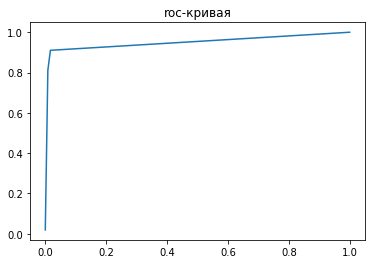

In [279]:
plot_roc(cancer_x, cancer_y, 'cancer', me_cancer_best, me_cancer_rules,
         'misclassification error', 'M', 'B')

Датасет: cancer
Функция impurity: entropy
Оптимальная глубина дерева: 2
ROC-AUC: 0.9728410232017335


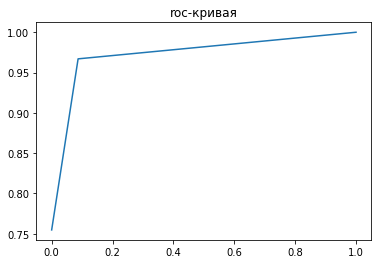

In [43]:
plot_roc(cancer_x, cancer_y, 'cancer', ent_cancer_best, ent_cancer_rules,
         'entropy', 'M', 'B')

Датасет: cancer
Функция impurity: Gini impurity
Оптимальная глубина дерева: 3
ROC-AUC: 0.9734620263199619


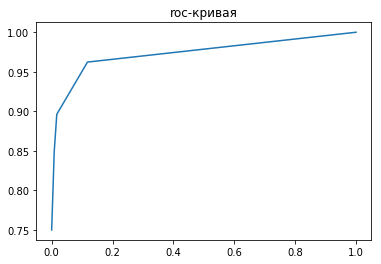

In [281]:
plot_roc(cancer_x, cancer_y, 'cancer', gini_cancer_best, gini_cancer_rules,
         'Gini impurity', 'M', 'B')

Датасет: spam
Функция impurity: misclassification error
Оптимальная глубина дерева: 9
ROC-AUC: 0.920927270051066


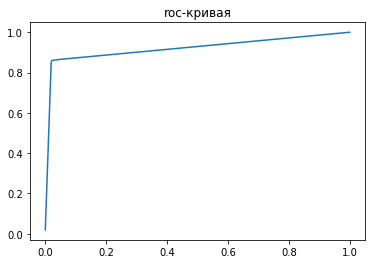

In [282]:
plot_roc(spam_x, spam_y, 'spam', me_spam_best, me_spam_rules,
         'misclassification error')

Датасет: spam
Функция impurity: entropy
Оптимальная глубина дерева: 10
ROC-AUC: 0.9762049513279274


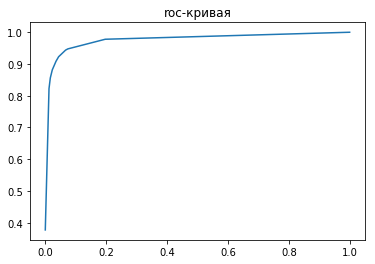

In [47]:
plot_roc(spam_x, spam_y, 'spam', ent_spam_best, ent_spam_rules,
         'entropy')

Датасет: spam
Функция impurity: Gini impurity
Оптимальная глубина дерева: 9
ROC-AUC: 0.9547533911389209


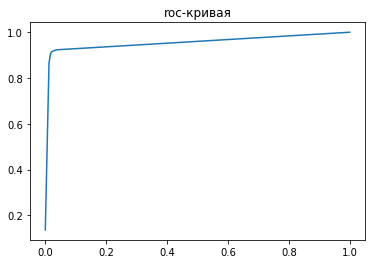

In [284]:
plot_roc(spam_x, spam_y, 'spam', gini_spam_best, gini_spam_rules,
         'Gini impurity')